In [1]:
import numpy as np
import matplotlib.pylab as plt
from scipy.stats import cauchy, norm, uniform, beta

# Cvičení: Monte Carlo odhad scale parametru Cauchyho rozdělení

Cílem tohoto cvičení je odhadnout škálovací parametr Cauchyho rozdělení. Toto rozdělení popisuje veličiny, které jsou zatíženy outliery. Pokud se takový šum "nabalí" na měřená data, je to docela problém.

Data si nagenerujeme uměle, abychom mohli porovnat výsledky s přednastaveným parametrem:

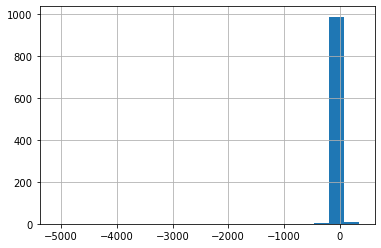

In [60]:
ndat = 1000
std = 1.8
x = cauchy.rvs(scale=std, size=ndat)
plt.hist(x, bins=20)
plt.show()

### Model
Uvažujeme $X_i \sim \mathit{Cauchy}(\gamma)$, kde $\gamma$ je scale parametr, udávající šířku distribuce.

$$
f(x_i|\gamma) = \frac{1}{\pi \gamma \left(1 + \frac{x_i}{\gamma}\right)^2}
$$

### Apriorno

Jako apriorní distribuci použijeme rovnoměrnou, $\gamma \sim \mathcal{U}(a,b)$. Pozor, $\gamma>0$. Rovněž je důležité, že náš odhad bude pokrývat pouze interval $[a,b]$ a nic mezi. Pokud by hodnota $\gamma$ ležela mimo něj, pak odhad dojede na jeden z krajů, tj. nejblíže, jak to jde.

$$
p(\gamma) = \frac{1}{b-a}
$$

### Aposteriorní hustota
Toto je nepříjemná situace - nemáme suficientní statistiku, která by nám informaci akumulovala. Násobíme celé hustoty (resp. věrohodnosti), což je numericky nestabilní. Proto budeme později počítat v logaritmech.

$$
\begin{aligned}
p(\gamma|x_{1:n}) &\propto p(\gamma) \cdot \prod_{i=1}^{n} f(x_i|\gamma) \\
&\propto \frac{1}{b-a} \cdot \prod_{i=1}^{n} \frac{1}{\pi \gamma \left(1 + \frac{x_i}{\gamma}\right)^2}
\end{aligned}
$$

In [61]:
def posterior_pdf(gamma, a, b, data):
    product = np.log(1/(b-a)) 
    product += np.sum(cauchy.logpdf(data, scale=gamma))
    return product #np.exp(product)

Vykreslíme si aposteriorní distribuci, abychom měli představu, jaký má tvar, zda support apriorna pokryl hodnotu $\gamma$ a pro představu, jak malé ty likelihoody jsou. Nemáme totiž znormováno, takže by se nám výsledek neintegroval do jedné. Ale jak víme, pro rejection sampling to nevadí, jde nám o tvar.

In [62]:
a = 0.1
b = 3.5
gammas = np.linspace(a, b, 100)
post = [posterior_pdf(gamma, a=a, b=b, data=x) for gamma in gammas]
post = np.array(post)
post -= post.max()
post = np.exp(post)

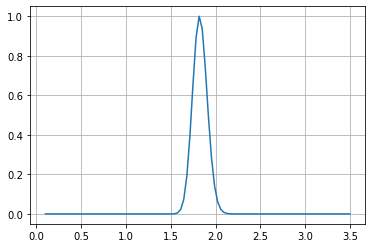

In [63]:
plt.plot(gammas, post)

Zkusíme navzorkovat a spočítat odhad $\gamma$ a jeho varianci:

/usr/lib/python3/dist-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


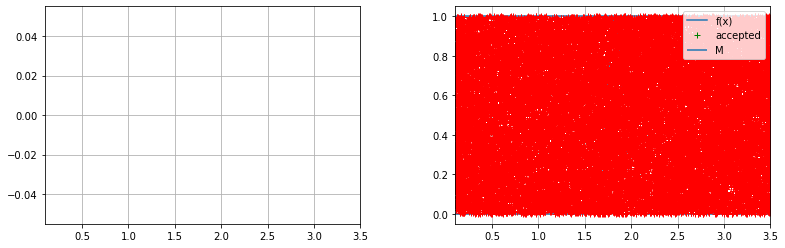

In [66]:
nsamples = 30000     ### Number of samples
M = post.max()       ### M

samples_gamma = uniform.rvs(a, b, size=nsamples)    # proposal samples
samples_u = uniform.rvs(0., M, size=nsamples)   # uniform samples
p_gamma = np.array([np.exp(posterior_pdf(sample, a=a, b=b, data=x)) for sample in samples_gamma]) # value of f(x)
accepted = np.where(samples_u < p_gamma)[0]

plt.figure(figsize=(13, 4))
plt.subplot(121)
plt.hist(samples_gamma[accepted], bins=30, density=True)
plt.xlim(a,b)
plt.subplot(122)
x = np.linspace(a, b, 100)
plt.plot(gammas, post, label='f(x)')
plt.hlines(M, x.min(), x.max(), label='M')
plt.plot(samples_gamma, samples_u, 'r+')
plt.plot(samples_gamma[accepted], samples_u[accepted], 'g+', label='accepted')
plt.xlim(a, b)
plt.legend()
plt.show()

In [65]:
print(f"% acceptance: {accepted.size/nsamples:.4f} ({accepted.size} of {nsamples})")
print(f"odhad E[gamma] = {samples_gamma[accepted].mean():.2f}")
print(f"odhad Var(gamma) = {samples_gamma[accepted].var():.2f}")

% acceptance: 0.0000 (0 of 30000)
odhad E[gamma] = nan
odhad Var(gamma) = nan


<ipython-input-65-47bf218bbcd1>:2: RuntimeWarning: Mean of empty slice.
  print(f"odhad E[gamma] = {samples_gamma[accepted].mean():.2f}")
/usr/lib/python3/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-65-47bf218bbcd1>:3: RuntimeWarning: Degrees of freedom <= 0 for slice
  print(f"odhad Var(gamma) = {samples_gamma[accepted].var():.2f}")
/usr/lib/python3/dist-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/usr/lib/python3/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
